In [30]:
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
import uproot
import awkward as ak

In [31]:
# file paths to signal and background files
f_sig = "samples/signal/signal_2018_aEM_minimal_cuts/output_sig_Mchi-21p0_dMchi-2p0_ct-1.root"
f_bkg = "samples/bkg/bkg_2018_QCD_TuneCP5_PSWeights_minimal_cuts/output_QCD_HT1500to2000.root"

fs = uproot.open(f_sig)["outT"] # opening the file, retrieve the TTree object called "outT"
fb = uproot.open(f_bkg)["outT"] # opening the file, retrieve the TTree object called "outT"

In [32]:
fs # TTree data type; each branch corresponds to a variable

<TTree 'outT' (218 branches) at 0x7f7de044b610>

In [33]:
fs.keys() # print available variables

['sel_vtx_typ',
 'sel_vtx_vxy',
 'sel_vtx_sigmavxy',
 'sel_vtx_vx',
 'sel_vtx_vy',
 'sel_vtx_vz',
 'sel_vtx_reduced_chi2',
 'sel_vtx_prob',
 'sel_vtx_dR',
 'sel_vtx_sign',
 'sel_vtx_minDxy',
 'sel_vtx_METdPhi',
 'sel_vtx_pt',
 'sel_vtx_eta',
 'sel_vtx_phi',
 'sel_vtx_energy',
 'sel_vtx_m',
 'sel_vtx_px',
 'sel_vtx_py',
 'sel_vtx_pz',
 'sel_vtx_PFIso4',
 'sel_vtx_PFRelIso4',
 'sel_vtx_PFIso3',
 'sel_vtx_PFRelIso3',
 'sel_vtx_PFIso8',
 'sel_vtx_PFRelIso8',
 'sel_vtx_e1_typ',
 'sel_vtx_e1_idx',
 'sel_vtx_e2_typ',
 'sel_vtx_e2_idx',
 'sel_vtx_match',
 'sel_e1_pt',
 'sel_e2_pt',
 'sel_e1_eta',
 'sel_e2_eta',
 'sel_e1_etaErr',
 'sel_e2_etaErr',
 'sel_e1_phi',
 'sel_e2_phi',
 'sel_e1_phiErr',
 'sel_e2_phiErr',
 'sel_e1_angRes',
 'sel_e2_angRes',
 'sel_e1_e',
 'sel_e2_e',
 'sel_e1_vxy',
 'sel_e2_vxy',
 'sel_e1_vz',
 'sel_e2_vz',
 'sel_e1_dxy',
 'sel_e2_dxy',
 'sel_e1_dxyErr',
 'sel_e2_dxyErr',
 'sel_e1_dz',
 'sel_e2_dz',
 'sel_e1_dzErr',
 'sel_e2_dzErr',
 'sel_e1_trkChi2',
 'sel_e2_trkChi2',
 

In [34]:
# retrieve array of reconstructed electron-positron vertex vxy
# vxy = displacement of the vertex from the collision point in the x-y plane
vtx_vxy = fs['sel_vtx_vxy'].array()

In [35]:
vtx_vxy

<Array [0.239, 0.0598, 0.0716, ... 1.18, 0.403] type='410 * float64'>

Data type is an "Awkward Array" (package called awkward : https://awkward-array.org/doc/main/). An awkward array is like a numpy array, but nested structure can be irregular e.g. arr = \[\[1,2,3\],\[4,5\]\] -- the first element has length 3, second has length 2. Numpy can only handle arrays with fixed shape, e.g. a 3x3 matrix. Awkward arrays are useful for us, because in general each collision event will have different numbers of particles. So, for example, if you want to record electron pT for all the electrons in each event, you'll need an awkward array because each event has a different number of electrons

In [36]:
# you can see each entry along the first axis (i.e. each event) 
# has different lengths along the second axis (i.e.number of electrons)
fs['Electron_pt'].array()

<Array [[158], [14], ... [7.46, 6.59, 1.97]] type='410 * var * float64'>

# Training a BDT classifier

First, we select what variables we think will be important for signal vs. background classification. I've included some of the most obvious ones here, but we should explore different options to see what's best. These are all 1D features, i.e. 1 value per event

In [37]:
features_1d = [
    "sel_vtx_vxy",
    "sel_vtx_sigmavxy",
    "sel_vtx_reduced_chi2",
    "sel_vtx_prob",
    "sel_vtx_dR",
    "sel_vtx_sign",
    "sel_vtx_minDxy",
    "sel_vtx_METdPhi",
    "sel_vtx_pt",
    "sel_vtx_eta",
    "sel_vtx_phi",
    "sel_vtx_m",
    "sel_vtx_PFRelIso4",
    "sel_vtx_PFRelIso8",
    "sel_e1_pt",
    "sel_e1_eta",
    "sel_e1_phi",
    "sel_e1_dxy",
    "sel_e1_dxyErr",
    "sel_e1_angRes",
    "sel_e1_trkChi2",
    "sel_e1_trkRelIso",
    "sel_e1_calRelIso",
    "sel_e1_PFRelIso",
    "CaloMET_pt",
    "PFMET_pt"
]

# additional features come from jets
# there are 1 or 2 jets per event, so these may not be 1d
# needs special handling when reading in data to turn them into 1d variables
jet_features = ['jet1_pt','jet1_eta','jet1_METdPhi','min_JetMETdPhi']

features = features_1d+jet_features

# combining signal samples for the four chi2 mean lifetimes : 1,10,100,1000 mm
sig_files = [
    "samples/signal/signal_2018_aEM_minimal_cuts/output_sig_Mchi-21p0_dMchi-2p0_ct-1.root",
    "samples/signal/signal_2018_aEM_minimal_cuts/output_sig_Mchi-21p0_dMchi-2p0_ct-10.root",
    "samples/signal/signal_2018_aEM_minimal_cuts/output_sig_Mchi-21p0_dMchi-2p0_ct-100.root",
    "samples/signal/signal_2018_aEM_minimal_cuts/output_sig_Mchi-21p0_dMchi-2p0_ct-1000.root",
    "samples/signal/signal_2018_aEM_minimal_cuts/output_sig_Mchi-10p5_dMchi-1p0_ct-1.root",
    "samples/signal/signal_2018_aEM_minimal_cuts/output_sig_Mchi-10p5_dMchi-1p0_ct-10.root",
    "samples/signal/signal_2018_aEM_minimal_cuts/output_sig_Mchi-10p5_dMchi-1p0_ct-100.root",
    "samples/signal/signal_2018_aEM_minimal_cuts/output_sig_Mchi-10p5_dMchi-1p0_ct-1000.root",
    "samples/signal/signal_2018_aEM_minimal_cuts/output_sig_Mchi-31p5_dMchi-3p0_ct-1.root",
    "samples/signal/signal_2018_aEM_minimal_cuts/output_sig_Mchi-31p5_dMchi-3p0_ct-10.root",
    "samples/signal/signal_2018_aEM_minimal_cuts/output_sig_Mchi-31p5_dMchi-3p0_ct-100.root",
    "samples/signal/signal_2018_aEM_minimal_cuts/output_sig_Mchi-31p5_dMchi-3p0_ct-1000.root"
]
# combining QCD background samples from the highest HT bins (dominant after missing energy cut)
bkg_files = [
    "samples/bkg/bkg_2018_QCD_TuneCP5_PSWeights_minimal_cuts/output_QCD_HT300to500.root",
    "samples/bkg/bkg_2018_QCD_TuneCP5_PSWeights_minimal_cuts/output_QCD_HT500to700.root",
    "samples/bkg/bkg_2018_QCD_TuneCP5_PSWeights_minimal_cuts/output_QCD_HT700to1000.root",
    "samples/bkg/bkg_2018_QCD_TuneCP5_PSWeights_minimal_cuts/output_QCD_HT1000to1500.root",
    "samples/bkg/bkg_2018_QCD_TuneCP5_PSWeights_minimal_cuts/output_QCD_HT1500to2000.root",
    "samples/bkg/bkg_2018_QCD_TuneCP5_PSWeights_minimal_cuts/output_QCD_HT2000toInf.root",
    "samples/bkg/bkg_2018_WJets_minimal_cuts/output_WJetsLNu_HT100to200.root",
    "samples/bkg/bkg_2018_WJets_minimal_cuts/output_WJetsLNu_HT1200to2500.root",
    "samples/bkg/bkg_2018_WJets_minimal_cuts/output_WJetsLNu_HT200to400.root",
    "samples/bkg/bkg_2018_WJets_minimal_cuts/output_WJetsLNu_HT2500toInf.root",
    "samples/bkg/bkg_2018_WJets_minimal_cuts/output_WJetsLNu_HT400to600.root",
    "samples/bkg/bkg_2018_WJets_minimal_cuts/output_WJetsLNu_HT600to800.root",
    "samples/bkg/bkg_2018_WJets_minimal_cuts/output_WJetsLNu_HT800to1200.root",
    "samples/bkg/bkg_2018_ZJets_minimal_cuts/output_ZJetsNuNu_HT100to200.root",
    "samples/bkg/bkg_2018_ZJets_minimal_cuts/output_ZJetsNuNu_HT1200to2500.root",
    "samples/bkg/bkg_2018_ZJets_minimal_cuts/output_ZJetsNuNu_HT200to400.root",
    "samples/bkg/bkg_2018_ZJets_minimal_cuts/output_ZJetsNuNu_HT2500toInf.root",
    "samples/bkg/bkg_2018_ZJets_minimal_cuts/output_ZJetsNuNu_HT400to600.root",
    "samples/bkg/bkg_2018_ZJets_minimal_cuts/output_ZJetsNuNu_HT600to800.root",
    "samples/bkg/bkg_2018_ZJets_minimal_cuts/output_ZJetsNuNu_HT800to1200.root"
]

# load in signal data and event weights
sig_data = []
sig_weights = []
for f in sig_files:
    with uproot.open(f)['outT'] as tree:
        data = []
        event_wgt = tree['eventWgt'].array().to_numpy()
        for feat in features_1d:
            arr = tree[feat].array().to_numpy()
            data.append(arr.reshape(-1,1)) # add a new dimension for concatenation
        
        jet1_pt = tree["PFJet_pt"].array()[:,0].to_numpy() # retrieving pt of first jet in event (zeroth element)
        jet1_eta = np.abs(tree["PFJet_pt"].array()[:,0].to_numpy()) # eta
        jet1_METdPhi = tree["PFJet_METdPhi"].array()[:,0].to_numpy() # phi
        jet_minMETdPhi = ak.min(tree["PFJet_METdPhi"].array(),axis=1).to_numpy(allow_missing=False)
        
        data.append(jet1_pt.reshape(-1,1))
        data.append(jet1_eta.reshape(-1,1))
        data.append(jet1_METdPhi.reshape(-1,1))
        data.append(jet_minMETdPhi.reshape(-1,1))
        
        data = np.concatenate(data,axis=1)
        sig_data.append(data)
        sig_weights.append(event_wgt)
sig_data = np.concatenate(sig_data,axis=0)
sig_weights = np.concatenate(sig_weights,axis=0)

bkg_data = []
bkg_weights = []
for f in bkg_files:
    with uproot.open(f)['outT'] as tree:
        data = []
        event_wgt = tree['eventWgt'].array().to_numpy()
        for feat in features_1d:
            arr = tree[feat].array().to_numpy()
            data.append(arr.reshape(-1,1)) # add a new dimension for concatenation
        jet1_pt = tree["PFJet_pt"].array()[:,0].to_numpy() # retrieving pt of first jet in event (zeroth element)
        jet1_eta = np.abs(tree["PFJet_pt"].array()[:,0].to_numpy())
        jet1_METdPhi = tree["PFJet_METdPhi"].array()[:,0].to_numpy()
        jet_minMETdPhi = ak.min(tree["PFJet_METdPhi"].array(),axis=1).to_numpy(allow_missing=False)
        
        data.append(jet1_pt.reshape(-1,1))
        data.append(jet1_eta.reshape(-1,1))
        data.append(jet1_METdPhi.reshape(-1,1))
        data.append(jet_minMETdPhi.reshape(-1,1))
        
        data = np.concatenate(data,axis=1)
        bkg_data.append(data)
        bkg_weights.append(event_wgt)
bkg_data = np.concatenate(bkg_data,axis=0)
bkg_weights = np.concatenate(bkg_weights,axis=0)

In [38]:
sig_data.shape

(3416, 30)

In [39]:
bkg_data.shape

(793666, 30)

In [40]:
bkg_data = np.random.permutation(bkg_data)
sig_data = np.random.permutation(sig_data)
bkg_data = bkg_data[:100000]

Now, let's split our signal and background data into training/testing sets. We'll use 75% of each dataset for training, and 25% for testing. For our labels, we'll set 1 = signal, 0 = background

In [41]:
n_bkg = bkg_data.shape[0]
n_sig = sig_data.shape[0]

bkg_train, bkg_test = bkg_data[:int(0.75*n_bkg)], bkg_data[int(0.75*n_bkg):]
bkg_train_wgts, bkg_test_wgts = bkg_weights[:int(0.75*n_bkg)], bkg_weights[int(0.75*n_bkg):]
sig_train, sig_test = sig_data[:int(0.75*n_sig)], sig_data[int(0.75*n_sig):]
sig_train_wgts, sig_test_wgts = sig_weights[:int(0.75*n_sig)], sig_weights[int(0.75*n_sig):]

# merge training sets and shuffle
perm1 = np.random.permutation(bkg_train.shape[0]+sig_train.shape[0])
train = np.concatenate((bkg_train,sig_train),axis=0)[perm1]
train_wgts = np.concatenate((bkg_train_wgts,sig_train_wgts),axis=0)[perm1]
train_label = np.concatenate((np.zeros(bkg_train.shape[0]),np.ones(sig_train.shape[0])))[perm1]

perm2 = np.random.permutation(bkg_test.shape[0]+sig_test.shape[0])
test = np.concatenate((bkg_test,sig_test),axis=0)[perm2]
test_wgts = np.concatenate((bkg_test_wgts,sig_test_wgts),axis=0)[perm2]
test_label = np.concatenate((np.zeros(bkg_test.shape[0]),np.ones(sig_test.shape[0])))[perm2]

In [42]:
# construct Xgboost DMatrix for train and test set
train = xgb.DMatrix(data=train,label=train_label,weight=train_wgts,feature_names=features)
test = xgb.DMatrix(data=test,label=test_label,weight=test_wgts,feature_names=features)

In [43]:
# Set up XGBoost parameters, as in tutorial (this will need to be refined!)
param = {}

# Booster parameters
param['eta']              = 0.1 # learning rate
param['max_depth']        = 10  # maximum depth of a tree
param['subsample']        = 0.8 # fraction of events to train tree on
param['colsample_bytree'] = 0.8 # fraction of features to train tree on

# Learning task parameters
param['objective']   = 'binary:logistic' # objective function
param['eval_metric'] = 'error'           # evaluation metric for cross validation
param = list(param.items()) + [('eval_metric', 'logloss')] + [('eval_metric', 'rmse')]

num_trees = 100  # number of trees to make

In [44]:
# Now train the classifier
booster = xgb.train(param,train,num_boost_round=num_trees)

In [45]:
# Evaluate on test set
print(booster.eval(test))

[0]	eval-rmse:0.19060439435356741	eval-rmse:0.19060439435356741	eval-rmse:0.19060439435356741


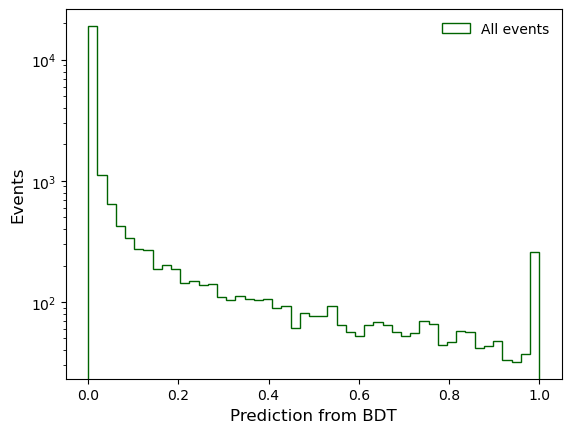

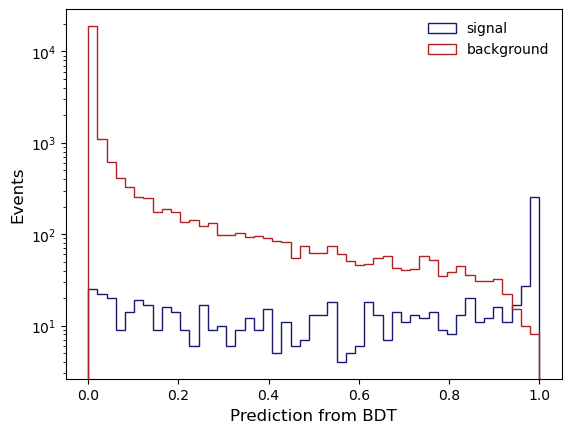

In [46]:
# calculate BDT score on test events and plot results
predictions = booster.predict(test)

# plot all predictions (both signal and background)
plt.figure();
plt.hist(predictions,bins=np.linspace(0,1,50),histtype='step',color='darkgreen',label='All events');
# make the plot readable
plt.xlabel('Prediction from BDT',fontsize=12);
plt.ylabel('Events',fontsize=12);
plt.legend(frameon=False);
plt.yscale('log')

# plot signal and background separately
plt.figure();
plt.hist(predictions[test.get_label().astype(bool)],bins=np.linspace(0,1,50),
         histtype='step',color='midnightblue',label='signal');
plt.hist(predictions[~(test.get_label().astype(bool))],bins=np.linspace(0,1,50),
         histtype='step',color='firebrick',label='background');
# make the plot readable
plt.xlabel('Prediction from BDT',fontsize=12);
plt.ylabel('Events',fontsize=12);
plt.legend(frameon=False);
plt.yscale('log')


/var/folders/hc/04l1bvsx4zd055rqmx5q22kw0000gn/T/ipykernel_24417/1780656143.py:11: RuntimeWarning: invalid value encountered in divide
  plt.plot(nsignal/len(sig_test),nsignal/(nsignal + nbackground),'o-',color='blueviolet');
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


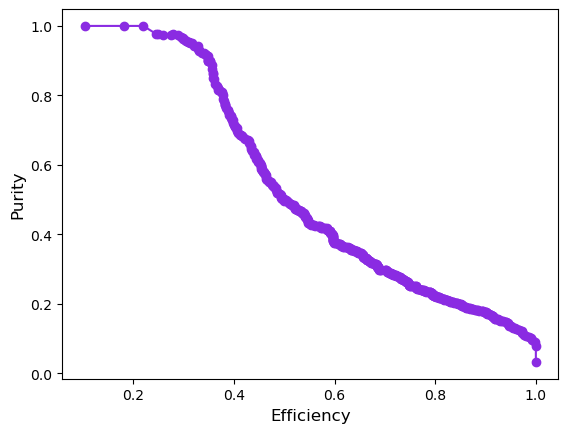

In [50]:
# Make a ROC curve
cuts = np.linspace(0,1,500);
nsignal = np.zeros(len(cuts));
nbackground = np.zeros(len(cuts));
for i,cut in enumerate(cuts):
    nsignal[i] = len(np.where(predictions[test.get_label().astype(bool)] > cut)[0]);
    nbackground[i] = len(np.where(predictions[~(test.get_label().astype(bool))] > cut)[0]);
    
# plot efficiency vs. purity (ROC curve)
plt.figure();
plt.plot(nsignal/len(sig_test),nsignal/(nsignal + nbackground),'o-',color='blueviolet');
# make the plot readable
plt.xlabel('Efficiency',fontsize=12);
plt.ylabel('Purity',fontsize=12);
plt.legend(frameon=False);


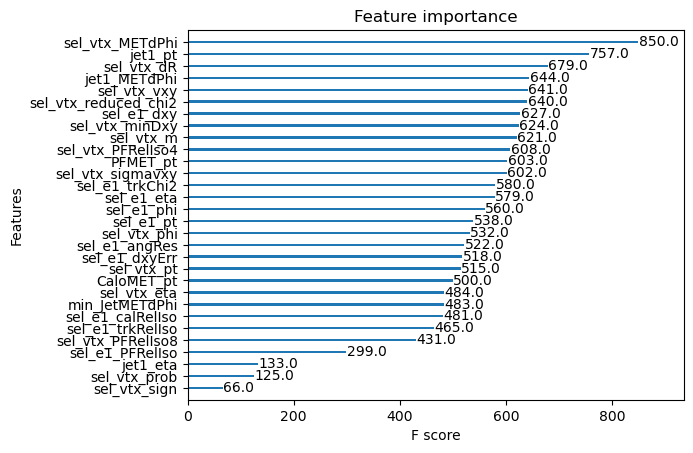

In [51]:
# plot importance of each variable
xgb.plot_importance(booster,grid=False);